# Solving the IRBC Model with Adaptive SG and DDSG
The material presented here supplements the work described in **[1]**, which introduces a highly performant time-iteration method for solving large-scale IRBC models. Embedded in the time-iteration solution method, the introduced DDSG algorithm is a highly scalable function approximation technique. The utilization of DDSG within the time-iteration has been shown to be highly effective in solving large-scale dynamic stochastic economic models. This algorithm was originally developed in C++ and Fortran using hybrid parallelism (OpenMP and MPI). However, the MPI parallel Python implementation presented here is intended to be more practical. The _DDSG_ class (see DDSG/DDSG.py) for function approximation (used for both DDSG and adaptive SG), and the _IRBC_ class (see IRBC/IRBC.py) for the IRBC model are required for the solution methods described in this notebook.

In this notebook we shows the basics of the IRBC model, solve the model with time-iteartion using adaptive SG and finally solving it using the introduced DDSG algorithem. For details on the model we refer the reader to both **[1]**, and **[2]** and also to hands on examples in **[3]**.

*References*
- **[1]** [High-Dimensional Dynamic Stochastic Model Representation, A. Eftekhari, S. Scheidegger, SIAM Journal on Scientific Computing (SISC), 2022](https://epubs.siam.org/doi/10.1137/21M1392231)
- **[2]** [Sparse Grids for Dynamic Economic Models J. Brumm, C. Krause, A. Schabb, S. Scheidegger](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3979412)
- **[3]** https://github.com/SparseGridsForDynamicEcon/SparseGrids_in_econ_handbook

In [10]:
import time
import numpy as np
from tabulate import tabulate

import os
import sys
import matplotlib.pyplot as plt

from IRBC import IRBC
from DDSG import DDSG
from scipy import optimize

## 1. IRBC Model 
We begin by first initilizing the IRBC model which follows the description of the two models (_smooth_ and _non-smooth_) described in **[2]**. With the default parameters set, we can initialize the model using the following steps:
1. Instatitate the IRBC model with the number of countries (say 2) and type of model (smooth or non-smooth), i.e., `model=IRBC(num_countries=2,irbc_type='non-smooth')`.
2. Set the parameters of the model, i.e.,`.set_parameters()`.  Note, all patamersts are set by defualt to those found in **[2]**.
3. Set the defualt integral rules, i.e., `.set_integral_rule()`. Notethat at the moment, only 'monomials_power' has been implemented and this is selected by default.
4. (optional) For confirmation, we can print the parameters of the model using `print_parameters()` method.

The main method of the IRBC object is the `.system_of_equations(x,state,p_last)` which is the value of the residual of the first-order-condtions optimiality conditions of the model. In particular, `x` is the policy to be solved, `state` is the state, and `p_last` is the last best estimate of the policy function (i.e., the current policy function). The zeros of this system of (non-linear) equations must be solved for all discrete states (i.e., grid points) in the statespace. This procedure of finding the policies that correspond to the equilibrium condition of the model at some states is encapsulated in the function `eq_condition(X)`. Note `eq_condition_init_guess(X)` is simply the intial guess of the policy function.

In [11]:
model = IRBC(num_countries=2, irbc_type='non-smooth')  
model.set_parameters()
model.set_integral_rule()
model.print_parameters()   

def eq_condition(X):  
    global p_last
    [n,d]=X.shape
    result = np.empty(shape=(n,model.grid_dof))
    for i in range(0,n):
        state    = X[i,:]
        p_guess  = p_last.eval(X[i,:].reshape(1,-1))
        solution = optimize.root(fun=model.system_of_equations, x0=p_guess,tol=1e-6,args=(state,p_last), method='hybr') 
        result[i,:] = solution.x        
    return result

def eq_condition_init_guess(X):
    [n,d]=X.shape
    val = np.empty(shape=(n,model.grid_dof))
    for i in range(0,n): 
        val[i,0:model.num_countries]  = (model.k_min + model.k_max)/2
        val[i,model.num_countries]    = 1
        val[i,model.num_countries+1:] = -0.1

    return val

Parameter                                               Variable    Value
------------------------------------------------------  ----------  -------------------------------
Intertemporal elasticity of substitution(IES)           gamma       ies_a+(i-1)(ies_b-ies_a)/(N-1)
IES factor a                                            ies_a       0.25
IES factor b                                            ies_b       1
Discount factor                                         beta        0.99
Capital share of income                                 zeta        0.36
Depreciation rate                                       delta       0.01
Persistence of total factor productivity shocks         rho_Z       0.95
Standard deviation of total factor productivity shocks  sig_E       0.01
Intensity of capital adjustment costs                   kappa       0.5
Lower bound for capital                                 k_min       0.8
Upper bound for capital                                 k_max       1.2
Agg

## 2. Time-Iteration
Here we implement the time-iteration algorithm, which consists of an incremental update of the policy function using the previous estimate of the policy function.To generate a baseline estimate of the policy function, we use the DDSG library, but with only SG. We can do this by _not_ calling the `set_decomposition()` method; see _examples/analytical_ for more details and examples of using the _DDSG_ library. Notice that `p_next` and `p_last` are the global variables that are called within `eq_condition`. After each iteration, we swap the policy and proceed to the next iteration. 

This baseline estimate is a crude approximation of the plocly function with refinement up to only level 1. The estimated policy function is saved to file using the 'dump()' method. We will reload it and use it to solve the optimal policy using adaptive SG and DDSG in parts 2.1 and 2.2, respectively.

In [12]:
# Max time-iteration iterations
iter_max = 300

# ASG parametrs
eps_sg   = 0
l_max    = 1

# Grid Domain Parameters
domain   = np.zeros((model.grid_dim,2))
domain[0:model.num_countries,0] = model.k_min
domain[0:model.num_countries,1] = model.k_max
domain[model.num_countries:,0]  = model.a_min
domain[model.num_countries:,1]  = model.a_max

# construct last grid
# this will initially hold the guessed policy
p_last = DDSG()
p_last.init(f_orical=eq_condition_init_guess,d=model.grid_dim,m=model.grid_dof) 
p_last.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
p_last.build(verbose=0)

# "course" time-iteration 
print('#time-iteration:')
for i in range(0,iter_max):
    
    p_next = DDSG()
    p_next.init(eq_condition,d=model.grid_dim,m=model.grid_dof)  
    p_next.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
    p_next.build(verbose=0)
    print(i,' ',end='')

    # swap policy
    p_last = p_next

p_next.dump('p_baseline',replace=True)

#time-iteration:
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218

### 2.1 Time-Iteration with Adaptive SG
Following the baseline estimate in section 2.0, we load it using `p_last = DDSG('p_baseline')` and continue with the time-iteration using adaptive SG, but this time with a higher refinement level. 
To evaluate the time-iteration statgnation, we sample the policy function with `X_sample` and return the L2-nrom.

In [13]:
# Max time-iteration iterations
iter_max = 5

# SG parametrs
l_max    = 5
eps_sg   = 1e-3

# sample points int the domain
X_sample = np.random.uniform(low=domain[:,0],high=domain[:,1],size=(1000,model.grid_dim))

# results
t_total_sg               =[]
grid_points_sg           =[]
error_l2_mean_sg         =[]

p_last = DDSG('p_baseline')
# time-iteration
for i in range(0,iter_max):
    
    # construct sparse grid 
    t_total_sg.append(-time.time())

    p_next = DDSG()
    p_next.init(eq_condition,d=model.grid_dim,m=model.grid_dof)  
    p_next.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
    p_next.build(verbose=0)
    
    t_total_sg[-1] += time.time()

    diff = p_next.eval(X_sample) - p_last.eval(X_sample)
    error_l2_mean_sg.append(np.linalg.norm(diff.flatten())/diff.size) 
    grid_points_sg.append(p_next.num_grid_points)

    print('#time-iteration:{:d} time(Sec.):{:.2e}  error_l2:{:.2e}  gridpoints:{:.2e}'.format(i,t_total_sg[-1],error_l2_mean_sg[-1],grid_points_sg[-1]) )
    
    # swap policy
    p_last = p_next

p_next.dump('p_sg',replace=True)

#time-iteration:0 time(Sec.):9.13e+00  error_l2:5.97e-05  gridpoints:1.04e+03
#time-iteration:1 time(Sec.):4.73e+00  error_l2:9.93e-06  gridpoints:1.04e+03
#time-iteration:2 time(Sec.):4.34e+00  error_l2:8.81e-06  gridpoints:1.04e+03
#time-iteration:3 time(Sec.):4.46e+00  error_l2:7.51e-06  gridpoints:1.05e+03
#time-iteration:4 time(Sec.):8.23e+00  error_l2:6.76e-06  gridpoints:1.06e+03


### 2.2 Time-Iteration with DDSG
Following the baseline estimate in section 2.0, we load it using `p_last = DDSG('p_baseline')` and continue with the time-iteration using adaptive DDSG with expansion order of 1. 
As before, we evaluate the time-iteration statgnation, we sample the policy function with `X_sample` and return the L2-nrom.

In [14]:
# Max time-iteration iterations
iter_max = 5

# DDSG parametrs
k_max    = 1
l_max    = 5
eps_sg   = 1e-3
eps_dd   = 1e-6

x0=np.mean(domain,axis=1).reshape((1,domain.shape[0]))

t_total_ddsg       =[]
grid_points_ddsg   =[]
error_l2_mean_ddsg =[]

p_last = DDSG('p_baseline')
for i in range(0,iter_max):
    
    t_total_ddsg.append(-time.time())

    p_next = DDSG()
    p_next.init(eq_condition,d=model.grid_dim,m=model.grid_dof)  
    p_next.set_grid(domain=domain,l_max=l_max,eps_sg=eps_sg)
    p_next.set_decomposition(x0,k_max=k_max,eps_rho=eps_dd,eps_eta=eps_dd)
    p_next.build(verbose=0)
    
    t_total_ddsg[-1] += time.time()

    diff = p_next.eval(X_sample) - p_last.eval(X_sample)
    error_l2_mean_ddsg.append(np.linalg.norm(diff.flatten())/diff.size) 
    grid_points_ddsg.append(p_next.num_grid_points)

    print('#time-iteration:{:d} time(Sec.):{:.2e}  error_l2:{:.2e}  gridpoints:{:.2e}'.format(i,t_total_ddsg[-1],error_l2_mean_ddsg[-1],grid_points_ddsg[-1]) )

    # swap policy
    p_last = p_next

p_next.dump('p_ddsg',replace=True)

#time-iteration:0 time(Sec.):4.34e+00  error_l2:8.12e-06  gridpoints:8.90e+01
#time-iteration:1 time(Sec.):6.04e-01  error_l2:6.61e-06  gridpoints:8.90e+01
#time-iteration:2 time(Sec.):3.02e+00  error_l2:5.56e-06  gridpoints:9.30e+01
#time-iteration:3 time(Sec.):6.71e-01  error_l2:4.94e-06  gridpoints:9.30e+01
#time-iteration:4 time(Sec.):6.28e-01  error_l2:4.66e-06  gridpoints:9.30e+01


## 3 Error Metrics
We present two types of metrics here. The first metric is the stagnation metric, which does not always correspond to the convergence. On each iteration, it is simply the L2 norm of the sampled policy function. This metric is shown below for experience in sections 2.1 and 2.2 in terms of cumulative runtime time and cumulative grid points.  

_The runtime difference (and grid points) between SG and DDSG grows significantly with increasing dimension, with DDSG being buch less._

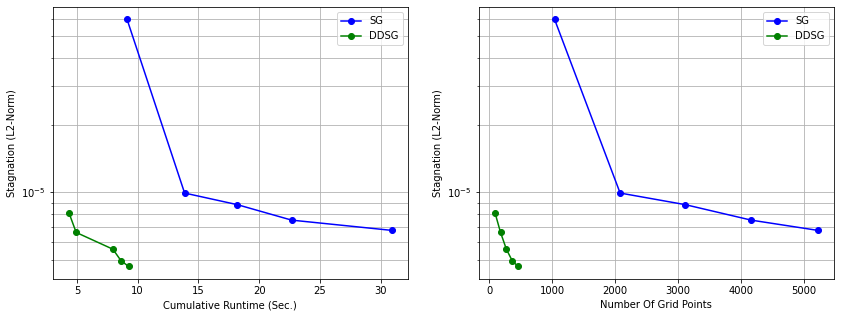

In [15]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1)
ax.plot(np.cumsum(t_total_sg)  ,error_l2_mean_sg,  '-o', color='blue',label="SG")
ax.plot(np.cumsum(t_total_ddsg),error_l2_mean_ddsg,'-o', color='green',label="DDSG")
ax.set_yscale('log')
ax.set_ylabel('Stagnation (L2-Norm)')
ax.set_xlabel('Cumulative Runtime (Sec.)')
ax.grid(visible=True, which='both',axis='both')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(np.cumsum(grid_points_sg)   ,error_l2_mean_sg,  '-o', color='blue',label="SG")
ax.plot(np.cumsum(grid_points_ddsg) ,error_l2_mean_ddsg,'-o', color='green',label="DDSG")
ax.set_yscale('log')
ax.set_ylabel('Stagnation (L2-Norm)')
ax.set_xlabel('Number Of Grid Points')
ax.grid(visible=True, which='both',axis='both')
ax.legend()

fig.show()

The errors reported here indicate how far the current policy and the policy for the next period are from optimal when calculated using the computed equilibrium policy function. Along the N-step simulation path, the errors are computed. We report the _average_ and _maximum_ (99.9%ile) simulation errors in log base 10. We can see that DDSG and SG have similar errors, but DDSG takes much less time and uses far fewer grid points.

In [16]:

# Number of simulation steps
N=11000

# evaluation simulation erro
def error_sim_eval(folder_name):
    p   = DDSG(folder_name)
    error = model.error_sim(policy_funcion=p,N=N)
    error = error[int(N*.1):,:] # Remove the frist N_ignore (burnin)
    error_econ_abs_mean=np.mean(np.abs(error.flatten()))
    error_econ_abs_max999=np.percentile(np.abs(error.flatten()),99.9)

    return  [error_econ_abs_mean,error_econ_abs_max999]

data=[]

error = error_sim_eval('p_sg')
data.append(['SG',np.log10(error[0]),np.log10(error[1]),np.sum(t_total_sg[-1]),np.sum(grid_points_sg[-1])])

error = error_sim_eval('p_ddsg')
data.append(['DDSG',np.log10(error[0]),np.log10(error[1]),np.sum(t_total_ddsg),np.sum(grid_points_ddsg)])

headers = ['Sim. Avg. Euler Error (log10)','Sim. Max. Euler Error (log10)','Cumulitive Runtime (Sec.)','Cumulitive Number of Grid Points']

print(tabulate(data,headers=headers))


        Sim. Avg. Euler Error (log10)    Sim. Max. Euler Error (log10)    Cumulitive Runtime (Sec.)    Cumulitive Number of Grid Points
----  -------------------------------  -------------------------------  ---------------------------  ----------------------------------
SG                           -1.751                           -1.45376                      8.22627                                1059
DDSG                         -1.77295                         -1.48821                      9.26019                                 457


## 4 Strong-Scaling

To run DDSG in parallel, the script must be executed using `mpirun`; for example, to run the script with four processes, use the command `mpirun -—bind-to core -np 4 python3 script.py`. The `-—bind-to core` flag ensures that the processes are linked to the machine's cores. 

Here we show scalablity of the DDSG time-iteation alogirthem. Unlike the previous examples, we use the _smooth_  IRBC model as the test case. We only take one iteartion for each test. In all test we fix maximimum SG refinment to level 8 and maximum expansion order to 1. We use two time-iteartion steps and report the cumulitive the number of grid-points and cumulitie runtime.

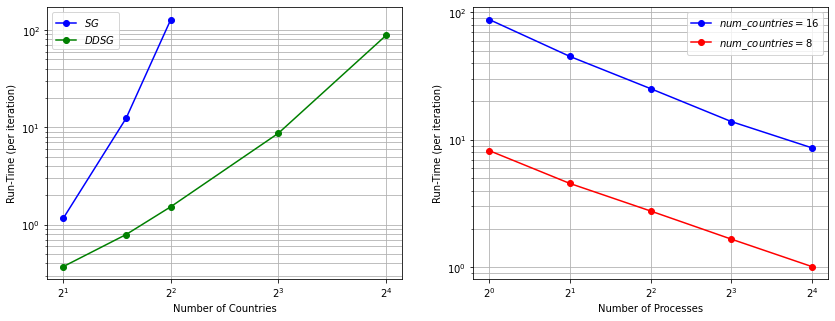

In [17]:
num_country_sg   = [2,3,4]
time_sg          = [1.16e+00,1.24e+01,1.28e+02]

#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 2 4 0 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 3 4 0 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 4 4 0 2

num_country_ddsg = [2,3,4,8,16]
time_ddsg        = [3.71e-01,7.93e-01,1.53e+00,8.70e+00,8.79e+01]
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 2 4 1 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 3 4 1 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 4 4 1 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 8 4 1 2
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 16 4 1 2

n_proc       = [1,2,4,8,16]
#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 16 4 1 2
#mpirun --bind-to core -np 2 python3 unit_test_IRBC.py 16 4 1 2
#mpirun --bind-to core -np 4 python3 unit_test_IRBC.py 16 4 1 2
#mpirun --bind-to core -np 8 python3 unit_test_IRBC.py 16 4 1 2
#mpirun --bind-to core -np 16 python3 unit_test_IRBC.py 16 4 1 2
time_ddsg_16 = [8.79e+01,4.51e+01,2.52e+01,1.39e+01,8.64e+00]

#mpirun --bind-to core -np 1 python3 unit_test_IRBC.py 8 4 1 2
#mpirun --bind-to core -np 2 python3 unit_test_IRBC.py 8 4 1 2
#mpirun --bind-to core -np 4 python3 unit_test_IRBC.py 8 4 1 2
#mpirun --bind-to core -np 8 python3 unit_test_IRBC.py 8 4 1 2
#mpirun --bind-to core -np 16 python3 unit_test_IRBC.py 8 4 1 2
time_ddsg_8  = [8.22e+00,4.54e+00,2.76e+00,1.66e+00,1.01e+00]

# Plot
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1)
ax.plot(num_country_sg,time_sg,'-o', color='blue')
ax.plot(num_country_ddsg,time_ddsg,'-o', color='green')
ax.set_ylabel('Run-Time (per iteration)')
ax.set_xlabel('Number of Countries')
ax.set_xticks(n_proc)
ax.set_yscale('log')
ax.set_xscale('log',base=2)
ax.grid(visible=True, which='both',axis='both')
ax.legend(['$SG$','$DDSG$'])

ax = fig.add_subplot(1,2,2)
ax.plot(n_proc,time_ddsg_16,'-o', color='blue')
ax.plot(n_proc,time_ddsg_8,'-o', color='red')
ax.set_ylabel('Run-Time (per iteration)')
ax.set_xlabel('Number of Processes')
ax.set_xticks(n_proc)
ax.set_yscale('log')
ax.set_xscale('log',base=2)
ax.legend(['$num\_countries=16$','$num\_countries=8$'])
ax.grid(visible=True, which='both',axis='both')
plt.show()